## Initial Setup



In [ ]:
import os
import math
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import Input
#from tensorflow.keras.layers import FilterResponseNormalization
from tensorflow.keras.layers import Add, Lambda, Multiply, Activation, Dense, Dropout, Conv2D, ConvLSTM2D, Conv2DTranspose, BatchNormalization, UpSampling2D,MaxPooling2D, concatenate, Flatten, Reshape
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model, Model

2024-03-05 19:50:06.322256: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Generating Synthetic Data
This part can be skipped if data is loaded directly from npy.


In [ ]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

# Parameters
Lx = 10.0      # Length of the domain in the x direction
Ly = 10.0      # Length of the domain in the y direction
Nx = 28        # Number of spatial points in the x direction
Ny = 28        # Number of spatial points in the y direction
Nt = 4000      # Number of time steps
D_a = 0.01     # Diffusion coefficient for variable a
D_b = 0.01     # Diffusion coefficient for variable b
D_c = 0.01     # Diffusion coefficient for variable c (combination of a and b)
alpha = 0.1    # Influence of variable_a on variable_b
beta = 0.2     # Coefficient for variable_a in variable_c
gamma = 0.3    # Coefficient for variable_b in variable_c
neighborhood_size = 3  # Size of the neighborhood for convolution
lag_a = 1      # Lag for variable_a
lag_b = 1      # Lag for variable_b
update_factor_b = 0.6  # Update factor for variable_b

# Spatial and temporal discretization
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)
dx = x[1] - x[0]
dy = y[1] - y[0]

# Time discretization
dt = 0.01      # Time step
t = np.linspace(0, Nt * dt, Nt)

# Initialize variables
variable_a = np.zeros((Nt, Nx, Ny))
variable_b = np.zeros((Nt, Nx, Ny))
variable_b_cf = np.zeros((Nt, Nx, Ny))
variable_c = np.zeros((Nt, Nx, Ny))
variable_c_cf = np.zeros((Nt, Nx, Ny))

# Initial conditions
variable_a[0, :, :] = np.exp(-((X - Lx/2)**2 + (Y - Ly/2)**2) / 4)
variable_b[0, :, :] = np.sin(np.pi * X / Lx) + alpha * variable_a[0, :, :]
#variable_b_cf[0, :, :] = np.cos(np.pi * X / Lx) + alpha * variable_a[0, :, :]
variable_c[0, :, :] = beta * variable_a[0, :, :] + gamma * variable_b[0, :, :]
variable_c_cf[0, :, :] = beta * variable_a[0, :, :] + gamma * variable_b[0, :, :]

# Time-stepping loop
for n in range(1, Nt):
    # Diffusion Equation for variable_a with time lag
    laplacian_a = (np.roll(variable_a[n-1, :, :], 1, axis=1) - 2 * variable_a[n-1, :, :] + np.roll(variable_a[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_a[n-1, :, :], 1, axis=0) - 2 * variable_a[n-1, :, :] + np.roll(variable_a[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_a = D_a * laplacian_a
    variable_a[n, :, :] = variable_a[n-1, :, :] + dt * diffusion_term_a

    # Diffusion Equation for variable_b with time lag and dependence on lagged variable_a
    laplacian_b = (np.roll(variable_b[n-1, :, :], 1, axis=1) - 2 * variable_b[n-1, :, :] + np.roll(variable_b[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_b[n-1, :, :], 1, axis=0) - 2 * variable_b[n-1, :, :] + np.roll(variable_b[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_b = D_b * laplacian_b
    variable_b[n, :, :] = (variable_b[n-1, :, :] + dt * (diffusion_term_b + alpha * np.roll(diffusion_term_a, lag_a, axis=(0, 1))))
    variable_b_cf[n, :, :] = (variable_b[n-1, :, :] + dt * (diffusion_term_b + alpha * np.roll(diffusion_term_a, lag_a, axis=(0, 1))))

    variable_b_cf[n,10:15,10:15] = update_factor_b * variable_b_cf[n,10:15,10:15]

    # Convolution to compute the mean of per-pixel neighborhood of variable_b (excluding the pixel itself)
    kernel_size = 3
    neighborhood_sum = scipy.ndimage.convolve(variable_b[n, :, :], np.ones((kernel_size, kernel_size)), mode='constant', cval=0)
    neighborhood_mean = (neighborhood_sum - variable_b[n, :, :]) / (kernel_size**2 - 1)

    # Diffusion Equation for variable_c with time lag and dependence on lagged variable_a and lagged variable_b
    laplacian_c = (np.roll(variable_c[n-1, :, :], 1, axis=1) - 2 * variable_c[n-1, :, :] + np.roll(variable_c[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_c[n-1, :, :], 1, axis=0) - 2 * variable_c[n-1, :, :] + np.roll(variable_c[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_c = D_c * laplacian_c
    variable_c[n, :, :] = variable_c[n-1, :, :] + dt * diffusion_term_c + beta * dt * np.roll(diffusion_term_a, lag_a, axis=(0, 1)) + gamma * dt * (np.roll(variable_b[n, :, :], lag_b, axis=(0, 1)) + neighborhood_mean)

#variable_b_cf = np.copy(variable_b)
#variable_b_cf[:,10:20,10:20] = variable_b_cf[:,10:20,10:20] * 1.5

for n in range(1, Nt):
  # Diffusion Equation for variable_c with time lag and dependence on lagged variable_a and lagged variable_b
    laplacian_cf = (np.roll(variable_c_cf[n-1, :, :], 1, axis=1) - 2 * variable_c_cf[n-1, :, :] + np.roll(variable_c_cf[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_c_cf[n-1, :, :], 1, axis=0) - 2 * variable_c_cf[n-1, :, :] + np.roll(variable_c_cf[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_cf = D_c * laplacian_cf
    variable_c_cf[n, :, :] = variable_c_cf[n-1, :, :] + dt * diffusion_term_cf + beta * dt * np.roll(diffusion_term_a, lag_a, axis=(0, 1)) + gamma * dt * (np.roll(variable_b_cf[n, :, :], lag_b, axis=(0, 1)) + neighborhood_mean)


In [ ]:
a = variable_a.reshape(4000, 28, 28, 1)
b = variable_b.reshape(4000, 28, 28, 1)
c = variable_c.reshape(4000, 28, 28, 1)
c_cf = variable_c_cf.reshape(4000, 28, 28, 1)
data = np.concatenate([a, b, c, c_cf], 3)
print(data.shape)

(4000, 28, 28, 4)


Dividing data into input data, outcome, covariates, and counterfactuals

In [ ]:
data = data[:,:,:,:]
cov = data[:,:,:,:-2]
cf_data = data[:,:,:,-1]
target = data[:,:,:,-2]
data = data[:,:,:,:-1]

print(cf_data.shape)
print(data.shape)
print(cov.shape)
print(target.shape)

(4000, 28, 28)
(4000, 28, 28, 3)
(4000, 28, 28, 2)
(4000, 28, 28)


In [ ]:
#Adding a lag to target
lag = 1

data = data[:-lag,:,:,:]
target = target[lag:,:,:]
cf_data = cf_data[lag:,:,:]
cov = cov[:-lag,:,:]

In [ ]:
## Shifting treatment to last column
tr = data[:,:,:,-2].copy()
tr = tr.reshape(data.shape[0], data.shape[1], data.shape[2],1)
print(tr.shape)
print(data.shape)
data = np.delete(data, -2, 3)
print(data.shape)
data = np.concatenate([data, tr], 3)
print(data.shape)

(3999, 28, 28, 1)
(3999, 28, 28, 3)
(3999, 28, 28, 2)
(3999, 28, 28, 3)


In [ ]:
LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = LEN_DATA

print('LEN_DATA:',LEN_DATA)
print('NUM_TRAIN:',NUM_TRAIN)

x_train = data[:,:,:,:]
x_test = data[:,:,:,:]

#Create xtest2 of treatment and covariate history
x_test2 = cov[:,:,:,:]


#split features and labels
y_train=target[:,:,:] #target is last column
y_test=target[:,:,:]  #target is last column

LEN_DATA: 3999
NUM_TRAIN: 3999


In [ ]:
print('x_train.shape:',x_train.shape)
print('y_train.shape:',y_train.shape)

print('x_test.shape:',x_test.shape)
print('y_test.shape:',y_test.shape)

x_train.shape: (3999, 28, 28, 3)
y_train.shape: (3999, 28, 28)
x_test.shape: (3999, 28, 28, 3)
y_test.shape: (3999, 28, 28)


In [ ]:
#Replacing all nans with Zeros
x_train = np.nan_to_num(x_train)
y_train = np.nan_to_num(y_train)
x_test = np.nan_to_num(x_test)
y_test = np.nan_to_num(y_test)

In [ ]:
#Applying treatment to selective region

x_treated = np.copy(x_test)
x_treated[:,10:15,10:15,-1] = x_treated[:,10:15,10:15,-1]*(0.6)

### Reshaping Input and Target Features

In [ ]:
# convert an array of values into a dataset matrix
def reshape_features(dataset, samples, lat, lon, features):
    print(dataset.shape)
    X = dataset.reshape(samples, lat, lon, features)
    return X

# convert an array of values into a dataset matrix
def reshape_outcome(dataset, months, lat, lon):
    print(dataset.shape)
    X = dataset.reshape(months, lat, lon)
    return X

### Normalization

In [ ]:
# normalize the features

scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,x_train.shape[-1])) #reshaping to 2d for standard scaling
x_test = scaler_f.transform(x_test.reshape(-1,x_test.shape[-1])) #reshaping to 2d for standard scaling
x_treated = scaler_f.transform(x_treated.reshape(-1,x_treated.shape[-1])) #reshaping to 2d for standard scaling

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,1)) #reshaping to 2d for standard scaling
y_test = scaler_l.transform(y_test.reshape(-1,1)) #reshaping to 2d for standard scaling


In [ ]:
#Reshaping data to 3D for modeling
lat = 28
lon = 28
features = 3
timestep = 1

x_train = reshape_features(x_train, NUM_TRAIN, lat, lon, features) # reshaping to 3d for model
x_test = reshape_features(x_test, NUM_TRAIN, lat, lon, features) # reshaping to 3d for model
x_treated = reshape_features(x_treated, NUM_TRAIN, lat, lon, features) #reshaping to 2d for standard scaling


y_train = reshape_outcome(y_train, NUM_TRAIN, lat, lon) # reshaping to 3d for model
y_test = reshape_outcome(y_test, NUM_TRAIN, lat, lon) # reshaping to 3d for model

(3135216, 3)
(3135216, 3)
(3135216, 3)
(3135216, 1)
(3135216, 1)


In [ ]:
print('x_train.shape:',x_train.shape)
print('y_train.shape:',y_train.shape)

print('x_test.shape:',x_test.shape)
print('x_treated.shape:',x_treated.shape)
#print('x_treated2.shape:',x_treated2.shape)
print('y_test.shape:',y_test.shape)

x_train.shape: (3999, 28, 28, 3)
y_train.shape: (3999, 28, 28)
x_test.shape: (3999, 28, 28, 3)
x_treated.shape: (3999, 28, 28, 3)
y_test.shape: (3999, 28, 28)


In [ ]:
def sse_loss(y_true, y_pred):
    # Calculate the sum of squared error
    error = y_true - y_pred
    squared_error = tf.square(error)
    sse = tf.reduce_sum(squared_error)
    return sse

In [ ]:
lat = 28
lon = 28
features = 3 #actual features
timestep = 1

input_shape = (lat, lon, features)

learning_rate=1e-4
filter_size=3
use_temp_scaling=False
n_output_classes=1
metrics = RootMeanSquaredError()
print(input_shape)

(28, 28, 3)


In [ ]:
# based on the following manuscript
# https://arxiv.org/abs/1911.09737
# https://github.com/amirbar/FilterResponseNormalization/blob/master/frn.py


import tensorflow as tf
from tensorflow.compat.v1 import rsqrt
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints

class FRN(Layer):
    """
    Filter Response Normalization
    """
    def __init__(self,
                 axis=-1,
                 epsilon=1e-6,
                 learnable_epsilon=False,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 epsilon_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 epsilon_constraint=None,
                 **kwargs):
        '''
        :param axis: channels axis
        :param epsilon: for numeric stability (should be initialized to 1e-4 if learnable, or set to 1e-6 otherwise, cf. paper)
        :param learnable_epsilon: turn epsilon to trainable
        '''
        super(FRN, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.learnable_epsilon = learnable_epsilon
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.epsilon_regularizer = regularizers.get(epsilon_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)
        self.epsilon_constraint = constraints.get(epsilon_constraint)

    def build(self, input_shape):
        dim = input_shape[self.axis]

        if dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of '
                             'input tensor should have a defined dimension '
                             'but the layer received an input with shape ' +
                             str(input_shape) + '.')

        self.input_spec = InputSpec(ndim=len(input_shape),
                                    axes={self.axis: dim})
        shape = (dim,)

        self.gamma = self.add_weight(shape=shape,
                                     name='gamma',
                                     initializer=self.gamma_initializer,
                                     regularizer=self.gamma_regularizer,
                                     constraint=self.gamma_constraint)
        self.beta = self.add_weight(shape=shape,
                                    name='beta',
                                    initializer=self.beta_initializer,
                                    regularizer=self.beta_regularizer,
                                    constraint=self.beta_constraint)
        self.epsilon_l = self.add_weight(shape=(1,),
                                         name='epsilon_l',
                                         initializer=initializers.Constant(self.epsilon),
                                         regularizer=self.epsilon_regularizer,
                                         constraint=self.epsilon_constraint,
                                         trainable=self.learnable_epsilon)

        self.built = True

    def call(self, x, **kwargs):
        nu2 = tf.reduce_mean(tf.square(x), axis=list(range(1, x.shape.ndims - 1)), keepdims=True)

        # Perform FRN.
        x = x * rsqrt(nu2 + tf.abs(self.epsilon_l))

        return self.gamma * x + self.beta

    def get_config(self):
        config = {
            'epsilon': self.epsilon,
            'learnable_epsilon': self.learnable_epsilon,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'epsilon_regularizer': regularizers.serialize(self.epsilon_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint),
            'epsilon_constraint': constraints.serialize(self.epsilon_constraint),
        }
        base_config = super(FRN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape


class TLU(Layer):
    """
    Thresholded Linear Unit: augmented ReLU with a learned threshold (tau)
    """
    def __init__(self,
                 axis=-1,
                 tau_initializer='zeros',
                 tau_regularizer=None,
                 tau_constraint=None,
                 **kwargs):
        '''
        :param axis: channels axis
        '''
        super(TLU, self).__init__(**kwargs)
        self.axis = axis
        self.tau_initializer = initializers.get(tau_initializer)
        self.tau_regularizer = regularizers.get(tau_regularizer)
        self.tau_constraint = constraints.get(tau_constraint)

    def build(self, input_shape):
        dim = input_shape[self.axis]

        if dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of '
                             'input tensor should have a defined dimension '
                             'but the layer received an input with shape ' +
                             str(input_shape) + '.')

        self.input_spec = InputSpec(ndim=len(input_shape),
                                    axes={self.axis: dim})
        shape = (dim,)

        self.tau = self.add_weight(shape=shape,
                                    name='tau',
                                    initializer=self.tau_initializer,
                                    regularizer=self.tau_regularizer,
                                    constraint=self.tau_constraint)

        self.built = True

    def call(self, x, **kwargs):
        return tf.maximum(x, self.tau)

    def get_config(self):
        config = {
            'tau_initializer': initializers.serialize(self.tau_initializer),
            'tau_regularizer': regularizers.serialize(self.tau_regularizer),
            'tau_constraint': constraints.serialize(self.tau_constraint)
        }
        base_config = super(TLU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
    input = Input(shape = input_shape)

    #UNet-----start-----------
    conv1 = Conv2D(32, filter_size, activation='silu', padding='same', kernel_initializer='he_normal')(input)
    conv1 = Conv2D(32, filter_size, activation='silu', padding='same', kernel_initializer='he_normal')(conv1)
    bn1 = FRN()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(64, filter_size, activation='silu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, filter_size, activation='silu', padding='same', kernel_initializer='he_normal')(conv2)
    bn2 = FRN()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(128, filter_size, activation='silu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, filter_size, activation='silu', padding='same', kernel_initializer='he_normal')(conv3)
    bn3 = FRN()(conv3)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2), interpolation='bilinear')(bn3))
    merge8 = concatenate([up8, bn2], axis=3)
    conv8 = Conv2D(64, filter_size, activation='silu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(64, filter_size, activation='silu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = Conv2D(64, filter_size, activation='silu', padding='same', kernel_initializer='he_normal')(conv8)
    bn8 = FRN()(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2), interpolation='bilinear')(bn8))
    merge9 = concatenate([up9, bn1], axis=3)
    conv9 = Conv2D(32, filter_size, activation='silu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(32, filter_size, activation='silu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(32, filter_size, activation='silu', padding='same', kernel_initializer='he_normal')(conv9)
    #UNet-----end-----------

    output = Conv2D(n_output_classes, 1, activation='linear', name="unet_output")(conv9)

    model = Model(inputs = input, outputs = output)

In [ ]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d_42 (Conv2D)             (None, 28, 28, 32)   896         ['input_7[0][0]']                
                                                                                                  
 conv2d_43 (Conv2D)             (None, 28, 28, 32)   9248        ['conv2d_42[0][0]']              
                                                                                                  
 frn_12 (FRN)                   (None, 28, 28, 32)   65          ['conv2d_43[0][0]']              
                                                                                            

In [ ]:
learning_rate=1e-4
filter_size=3
use_temp_scaling=False
n_output_classes=1
loss = "mse"
metrics = RootMeanSquaredError()

model.compile(optimizer=Adam(learning_rate=learning_rate), loss=sse_loss, metrics = metrics)

In [ ]:
# define early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# fit model
print(x_train.shape, y_train.shape)
history = model.fit(x=x_train, y=y_train,epochs=60,batch_size=4,validation_split=.2,verbose = 2)


In [ ]:
train = model.evaluate(x_train, y_train)
print("Train MSE: {:.4f}\nTrain Loss: {:.4f}".format(train_mse, train_loss))

test = model.evaluate(x_test, y_test)
print("Test MSE: {:.4f}\nTest Loss: {:.4f}".format(test_mse, test_loss))

125/125 [==============================] - 5s 38ms/step - loss: 77.8610 - root_mean_squared_error: 0.0558


In [ ]:
y_pred = model.predict(x_test)
y_pred_cf = model.predict(x_treated)
print(y_pred.shape, y_pred_cf.shape)

125/125 [==============================] - 5s 38ms/step
(3999, 28, 28, 1) (3999, 28, 28, 1)


In [ ]:
print(y_pred_cf.min(), y_pred_cf.max())
print(y_pred.min(), y_pred.max())
print(y_test.min(), y_test.max())

-1.6146588 3.40778
-1.2907515 2.5590594
-1.2783139549065397 2.9003271490961864


In [ ]:
# invert scaling for forecasted values
inv_y_pred = scaler_l.inverse_transform(y_pred.reshape(-1,1))
inv_y_pred_cf = scaler_l.inverse_transform(y_pred_cf.reshape(-1,1))

# invert scaling for actual values
inv_y_test = scaler_l.inverse_transform(y_test.reshape(-1,1))

In [ ]:
print(inv_y_pred_cf.min(), inv_y_pred_cf.max())
print(inv_y_pred.min(), inv_y_pred.max())
print(inv_y_test.min(), inv_y_test.max())

-1.9993176 27.857004
-0.07382198 22.811712
0.00011360711509578181 24.840407690536477


In [ ]:
inv_y_pred = inv_y_pred.reshape(len(y_pred),28, 28)
print(inv_y_pred.shape)
inv_y_pred_cf = inv_y_pred_cf.reshape(len(y_pred_cf),28, 28)
print(inv_y_pred_cf.shape)
inv_y_test = inv_y_test.reshape(len(y_test),28, 28)
print(inv_y_pred.shape)

(3999, 28, 28)
(3999, 28, 28)
(3999, 28, 28)


In [ ]:
inv_y_test[1,1,1]- inv_y_pred[1,1,1]

-0.007118364064967686

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt

rmse = sqrt(mean_squared_error(inv_y_test.flatten(), inv_y_pred.flatten()))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.332


Direct ATE Calculation


1.6969643


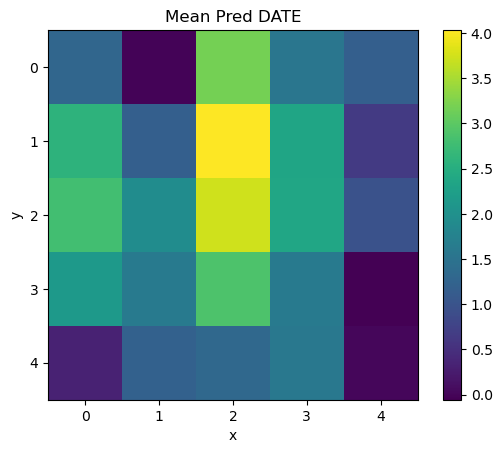

In [ ]:
pred_att = inv_y_pred_cf[:,10:15, 10:15] - inv_y_pred[:,10:15, 10:15]
mean_pred_att = np.mean(pred_att,axis=0)
print(np.mean(mean_pred_att))

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(mean_pred_att, cmap='viridis')
cbar = fig.colorbar(cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mean Pred DATE')
plt.show()

-1.5410311379574353


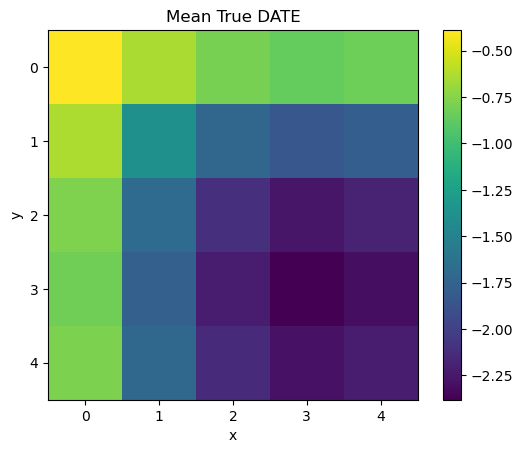

In [ ]:
true_att = cf_data[:,10:15, 10:15] - inv_y_test[:,10:15, 10:15]
mean_true_att = np.mean(true_att,axis=0)
print(np.mean(mean_true_att))

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(mean_true_att, cmap='viridis')
cbar = fig.colorbar(cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mean True DATE')
plt.show()

Lagged ATE calculation

0.13003162


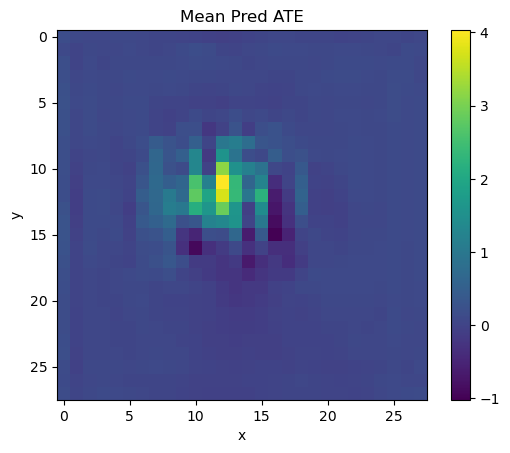

In [ ]:
#ATE for 200:500 timesteps
pred_ate = inv_y_pred_cf - inv_y_pred
mean_pred_ate = np.mean(pred_ate,axis=0)
print(np.mean(mean_pred_ate))

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(mean_pred_ate, cmap='viridis')
cbar = fig.colorbar(cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mean Pred ATE')
plt.show()

-0.09340695337404697
(28, 28)


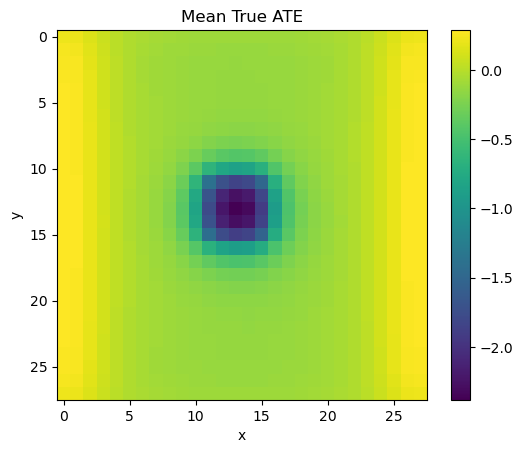

In [ ]:
#ATE for 200:500 timesteps
true_ate = cf_data - inv_y_test
mean_true_ate = np.mean(true_ate,axis=0)
print(np.mean(mean_true_ate))
print(mean_true_ate.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(mean_true_ate, cmap='viridis')
cbar = fig.colorbar(cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mean True ATE')
plt.show()

IATE Calculation

In [ ]:
#Mask for IATE
mask = np.ones((28, 28))
mask[10:15,10:15] = 0
#print(mask[10:15,10:15])
mask = mask.reshape(1,28, 28)
mask_ts = np.tile(mask, (4998, 1, 1))
#mask_ts.shape

-0.04426692984224102
(28, 28)


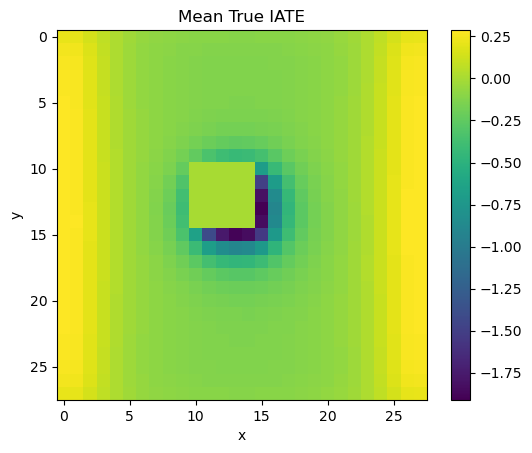

In [ ]:
#IATE for all timesteps

 = np.multiply(cf_data,mask_ts[:3999]) - np.multiply(inv_y_test,mask_ts[:3999])

mean_true_iate = np.mean(true_iate,axis=0) #* 100
print(np.mean(mean_true_iate))
print(mean_true_iate.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(mean_true_iate, cmap='viridis')
cbar = fig.colorbar(cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mean True IATE')
plt.show()

0.07591923433080432
(28, 28)


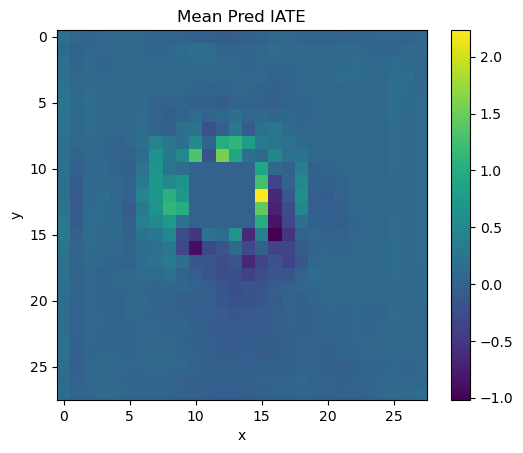

In [ ]:
#IATE for all timesteps

pred_iate = np.multiply(inv_y_pred_cf,mask_ts[:3999]) - np.multiply(inv_y_pred,mask_ts[:3999])

mean_pred_iate = np.mean(pred_iate,axis=0)
print(np.mean(mean_pred_iate))
print(mean_pred_iate.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(mean_pred_iate, cmap='viridis')
cbar = fig.colorbar(cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mean Pred IATE')
plt.show()

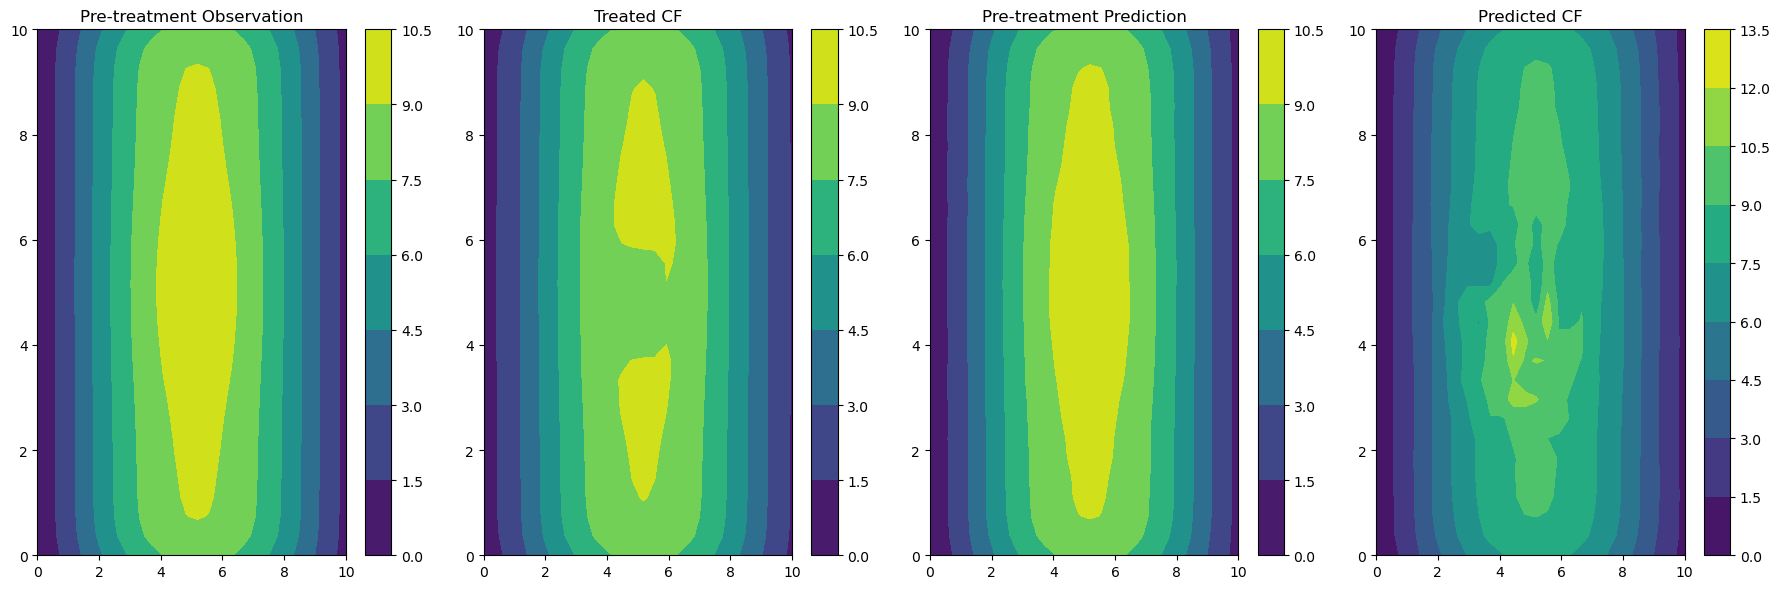

In [ ]:
# Plotting the final state of the variables
# Parameters
Lx = 10.0      # Length of the domain in the x direction
Ly = 10.0      # Length of the domain in the y direction
Nx = 28        # Number of spatial points in the x direction
Ny = 28        # Number of spatial points in the y direction

# Spatial and temporal discretization
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.contourf(X, Y, inv_y_test[1500, :, :], cmap='viridis')
plt.colorbar()
plt.title('Pre-treatment Observation')

plt.subplot(1, 4, 2)
plt.contourf(X, Y, cf_data[1500, :, :], cmap='viridis')
plt.colorbar()
plt.title('Treated CF')

plt.subplot(1, 4, 3)
plt.contourf(X, Y, inv_y_pred[1500, :, :], cmap='viridis')
plt.colorbar()
plt.title('Pre-treatment Prediction')

plt.subplot(1, 4, 4)
plt.contourf(X, Y, inv_y_pred_cf[1500, :, :], cmap='viridis')
plt.colorbar()
plt.title('Predicted CF')

plt.tight_layout()
plt.show()

In [ ]:
ts = inv_y_pred.shape[0]
time_series1 = np.array([np.mean(inv_y_pred_cf[i,:,:]) for i in range(ts)])
time_series2 = np.array([np.mean(cf_data[i,:,:]) for i in range(ts)])
print(time_series2.shape)

(3999,)


Text(0, 0.5, 'Outcome(Y)')

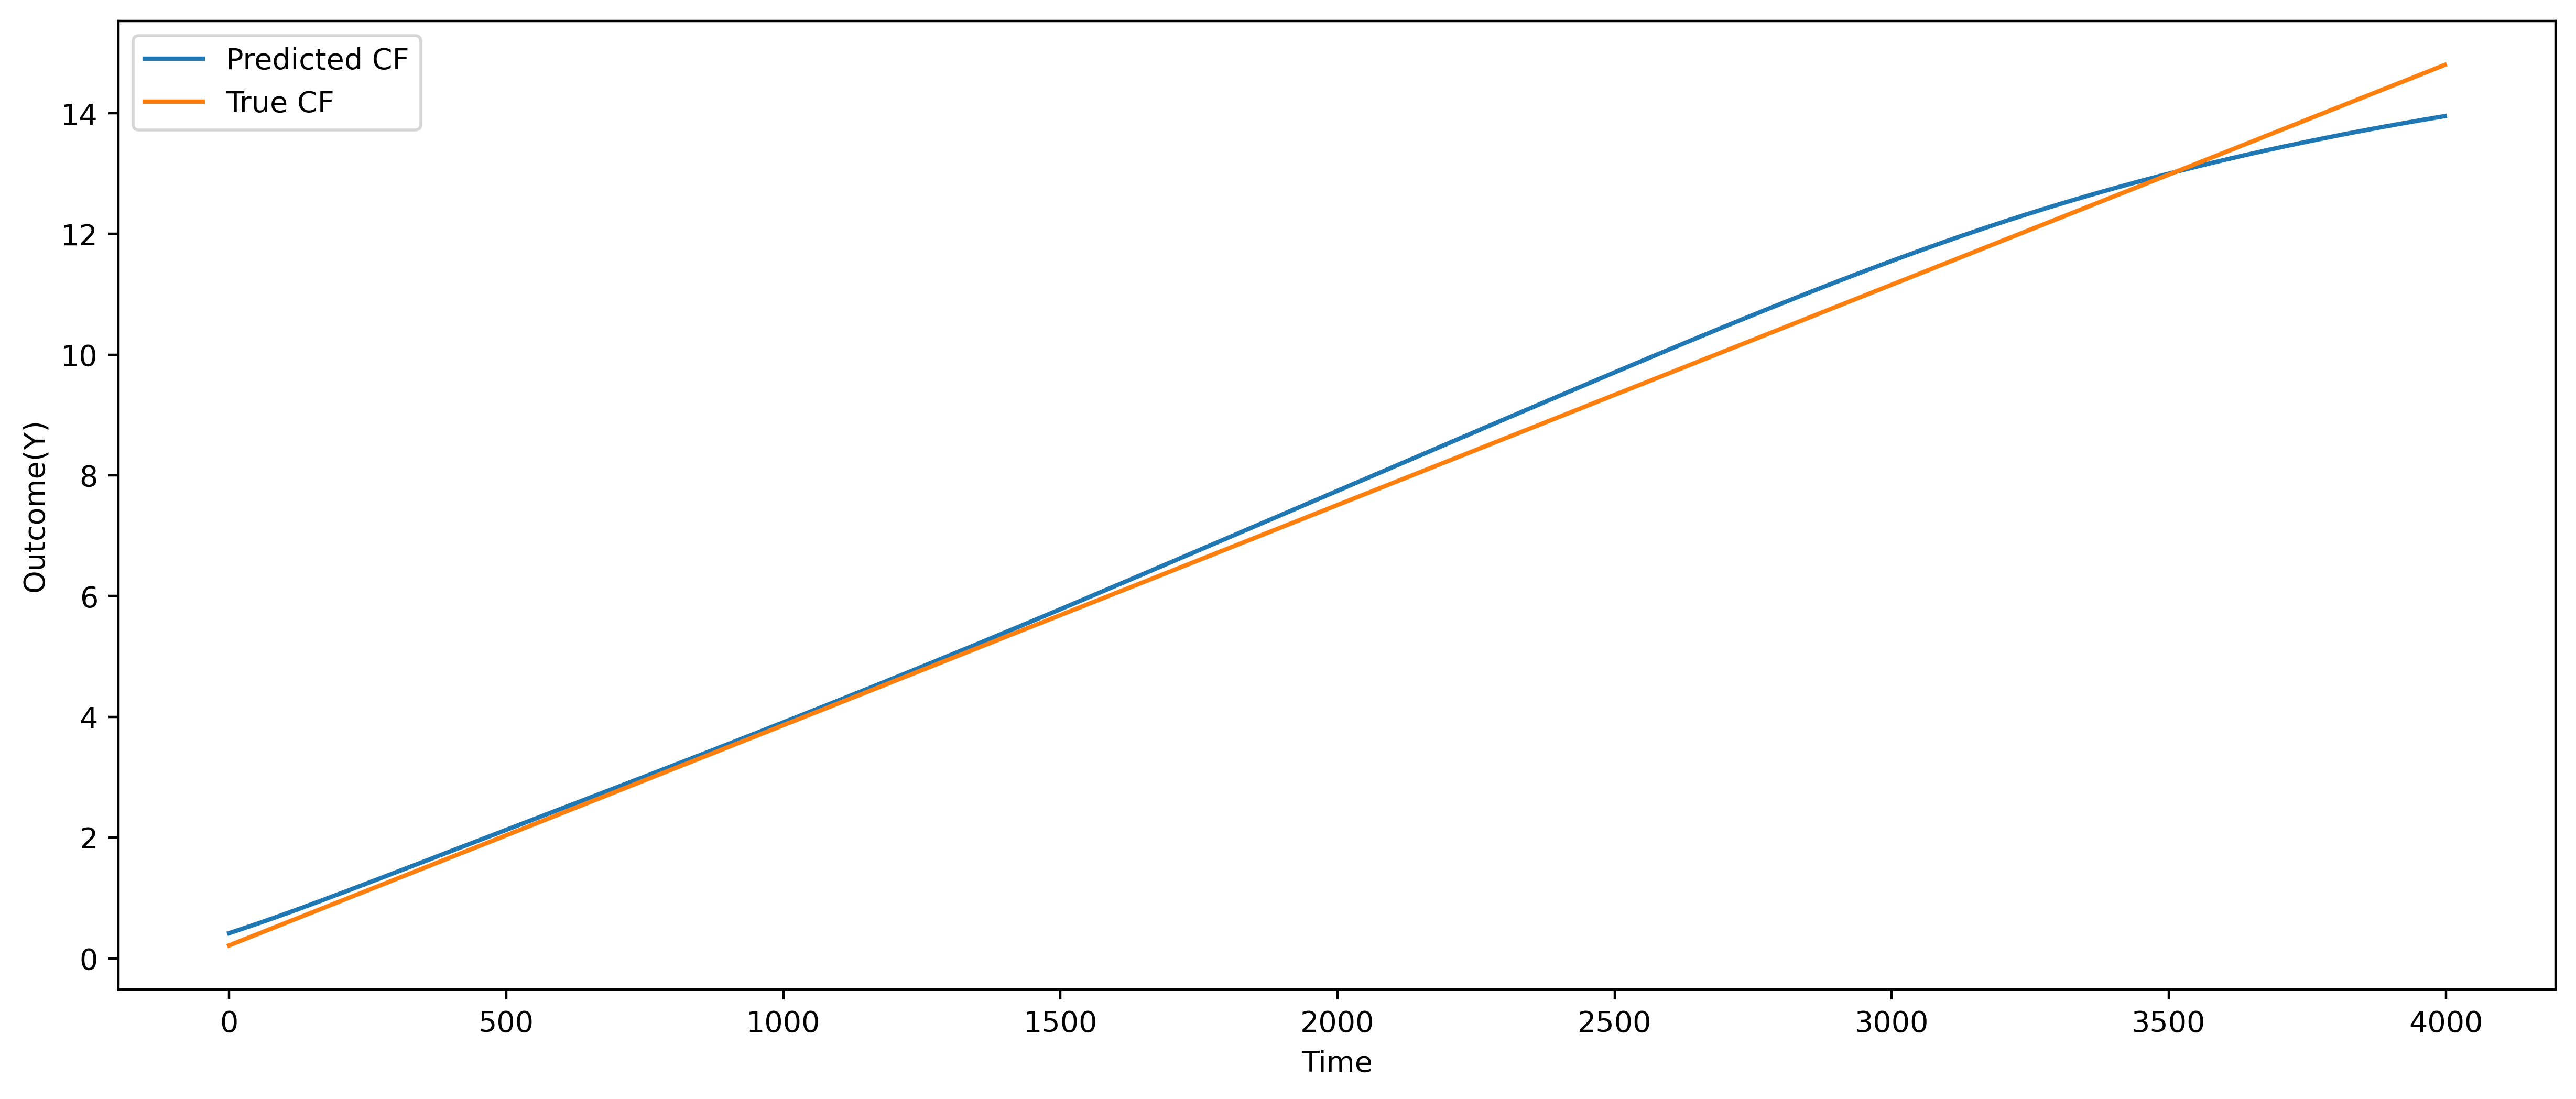

In [ ]:
fig,ax = plt.subplots(figsize = [15,6], dpi = 400)
ax.plot(range(ts),time_series1, label = "Predicted CF")
ax.plot(range(ts),time_series2, label = "True CF")
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel(r"Outcome(Y)")

In [ ]:
ts = inv_y_pred.shape[0]
time_series3 = np.array([np.mean(inv_y_pred_cf[i,10:15,10:15]) for i in range(ts)])
time_series4 = np.array([np.mean(cf_data[i,10:15,10:15]) for i in range(ts)])
print(time_series2.shape)

(3999,)


Text(0, 0.5, 'Outcome(Y)')

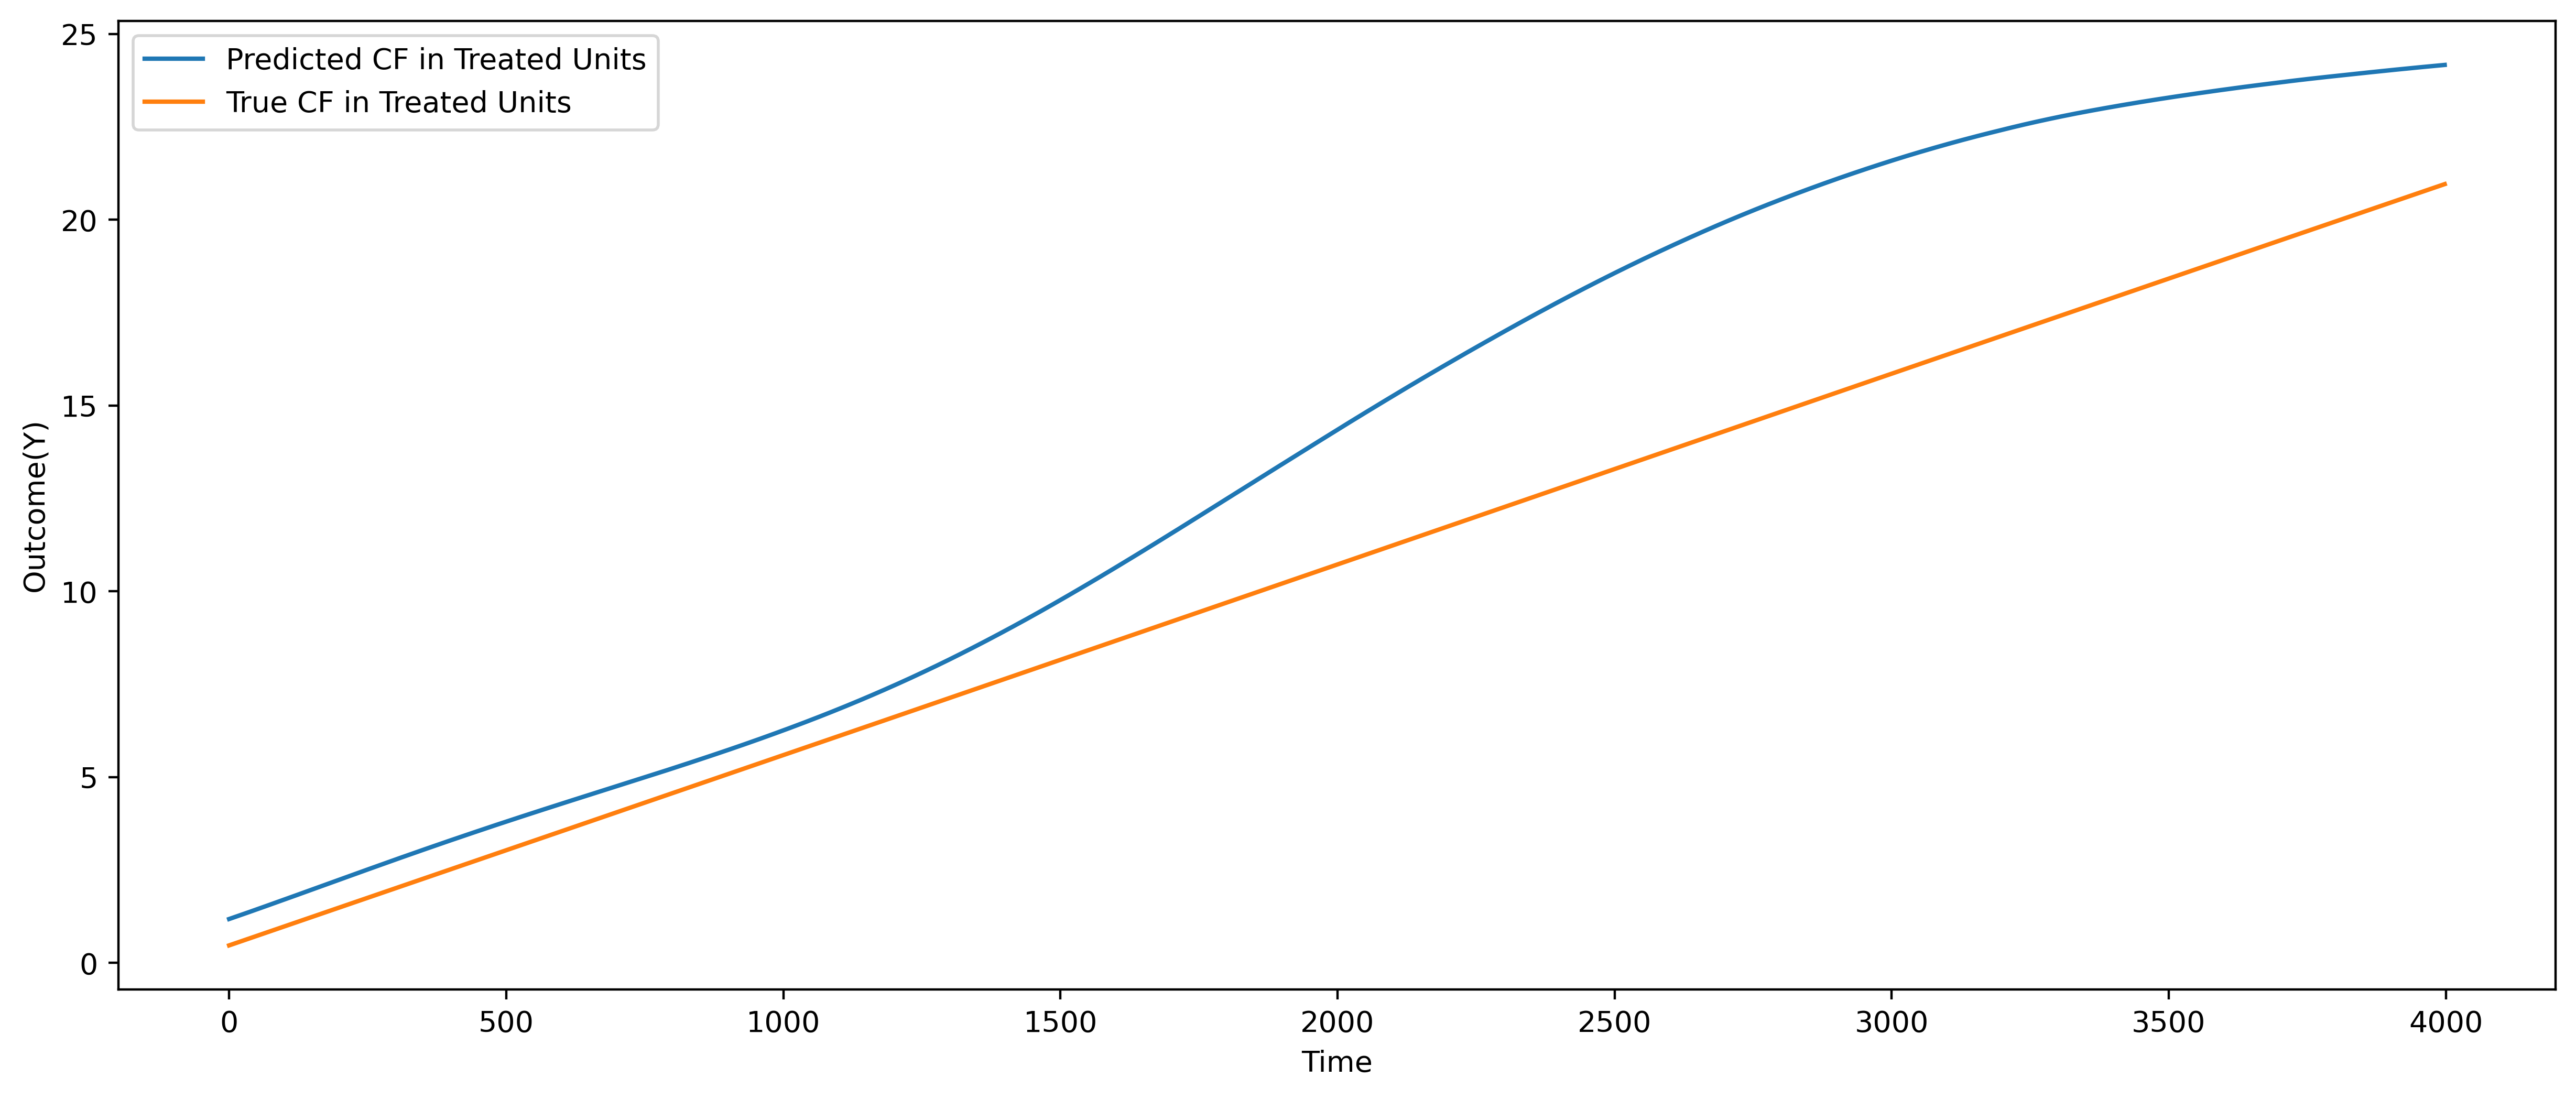

In [ ]:
fig,ax = plt.subplots(figsize = [15,6], dpi = 400)
ax.plot(range(ts),time_series3, label = "Predicted CF in Treated Units")
ax.plot(range(ts),time_series4, label = "True CF in Treated Units")
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel(r"Outcome(Y)")

In [ ]:
ts = inv_y_pred.shape[0]
time_series5 = np.array([np.mean(inv_y_test[i,:,:]) for i in range(ts)])
time_series6 = np.array([np.mean(cf_data[i,:,:]) for i in range(ts)])
print(time_series5.shape)

(3999,)


Text(0, 0.5, 'Outcome(Y)')

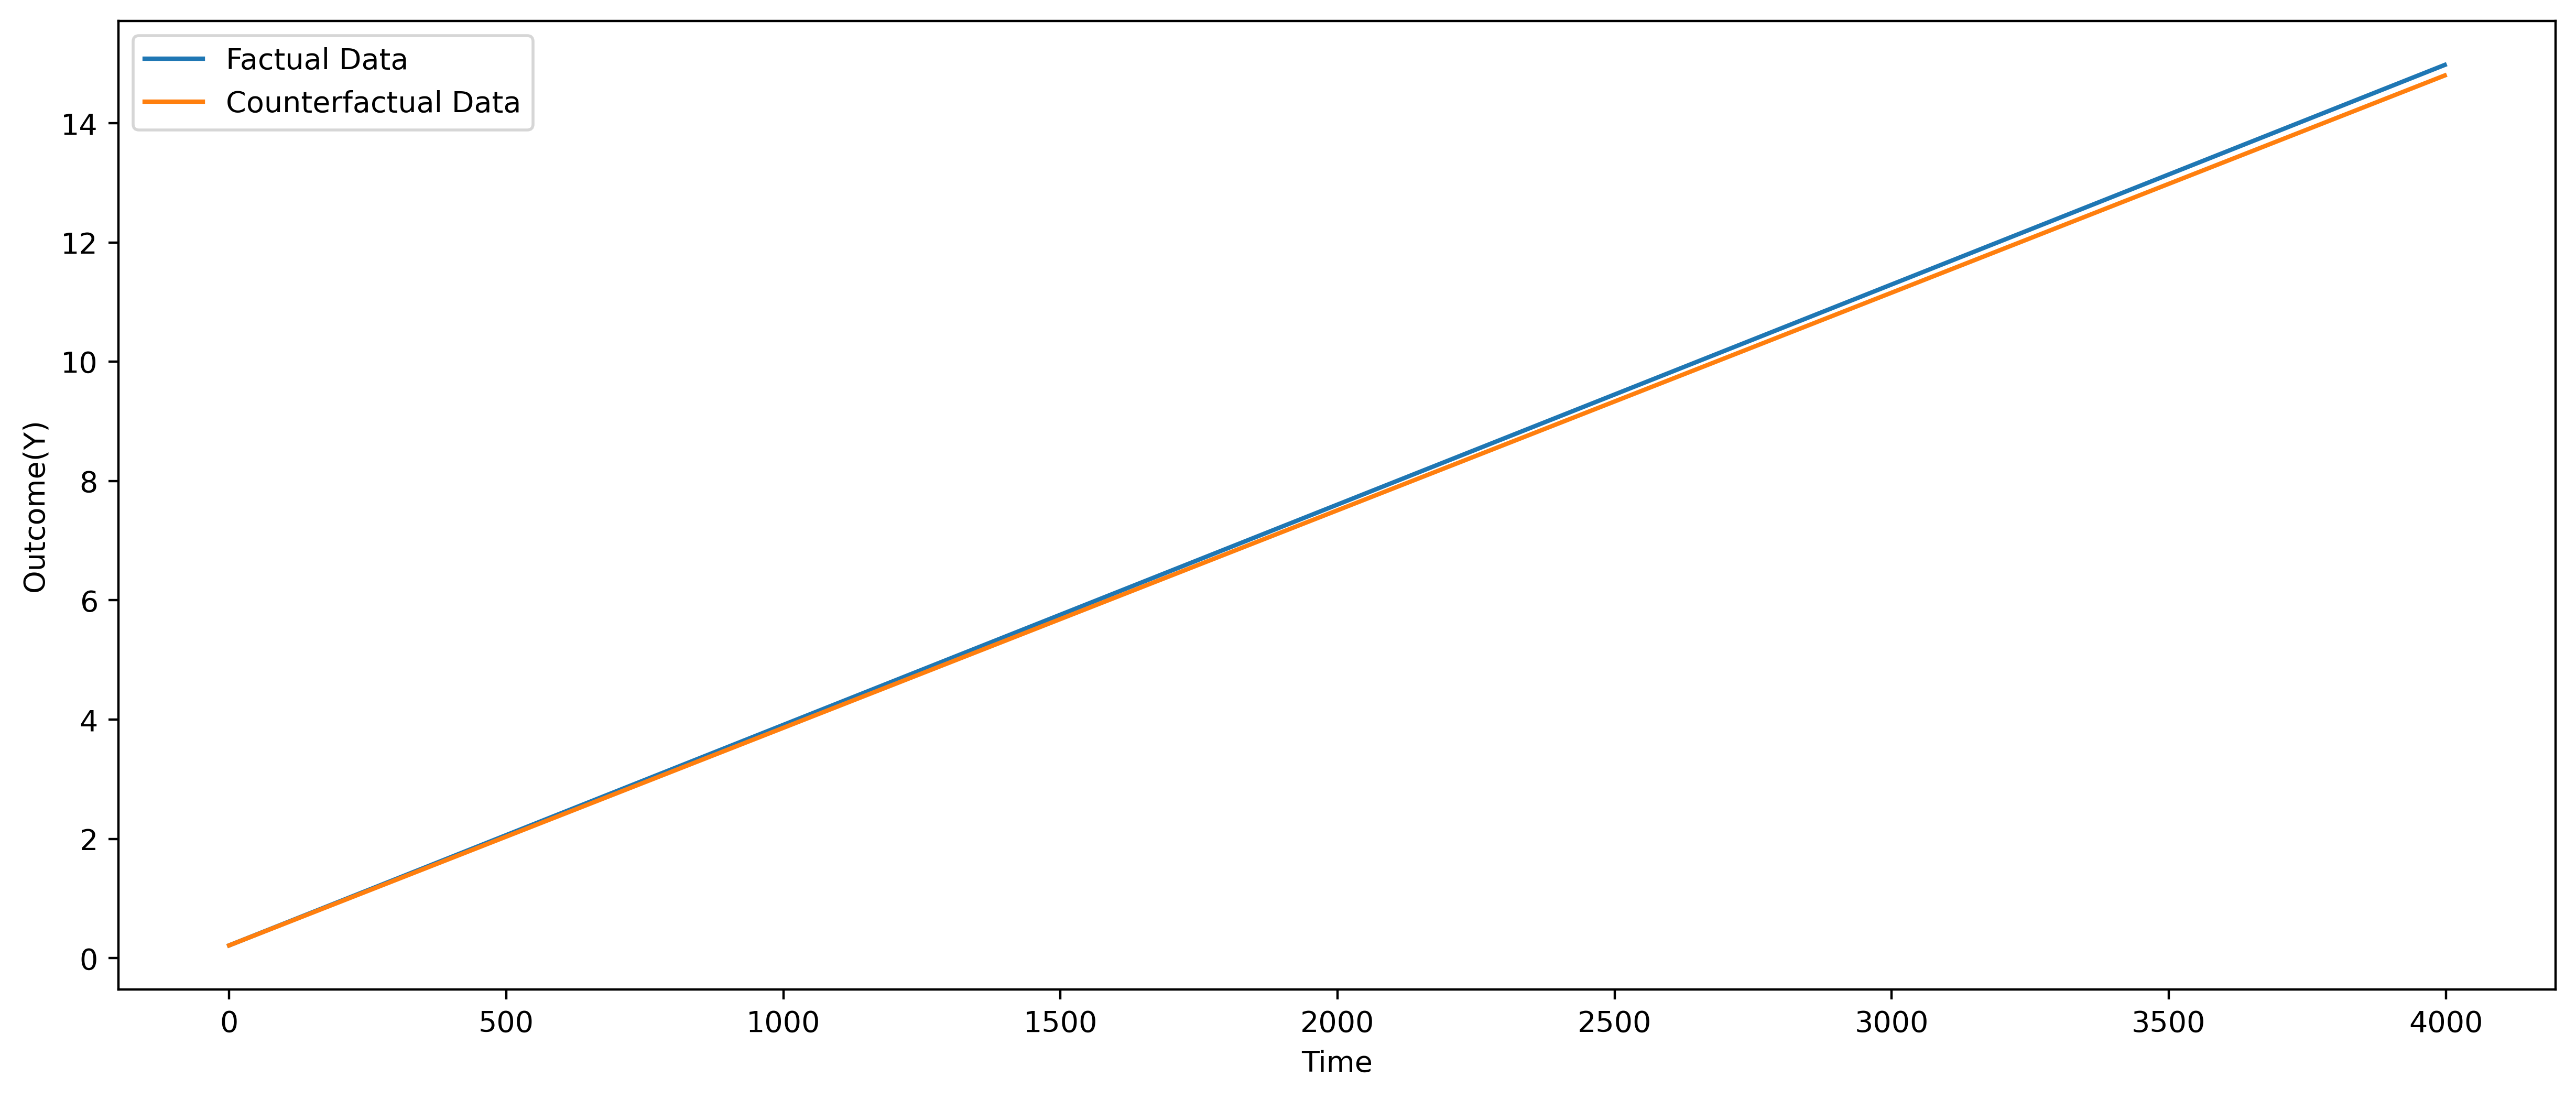

In [ ]:
fig,ax = plt.subplots(figsize = [15,6], dpi = 400)
ax.plot(range(ts),time_series5, label = "Factual Data")
ax.plot(range(ts),time_series6, label = "Counterfactual Data")
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel(r"Outcome(Y)")

In [ ]:
ts = inv_y_pred.shape[0]
time_series7 = np.array([np.mean(inv_y_test[i,:,:]) for i in range(ts)])
time_series8 = np.array([np.mean(inv_y_pred[i,:,:]) for i in range(ts)])
print(time_series7.shape)

(3999,)


Text(0, 0.5, 'Outcome(Y)')

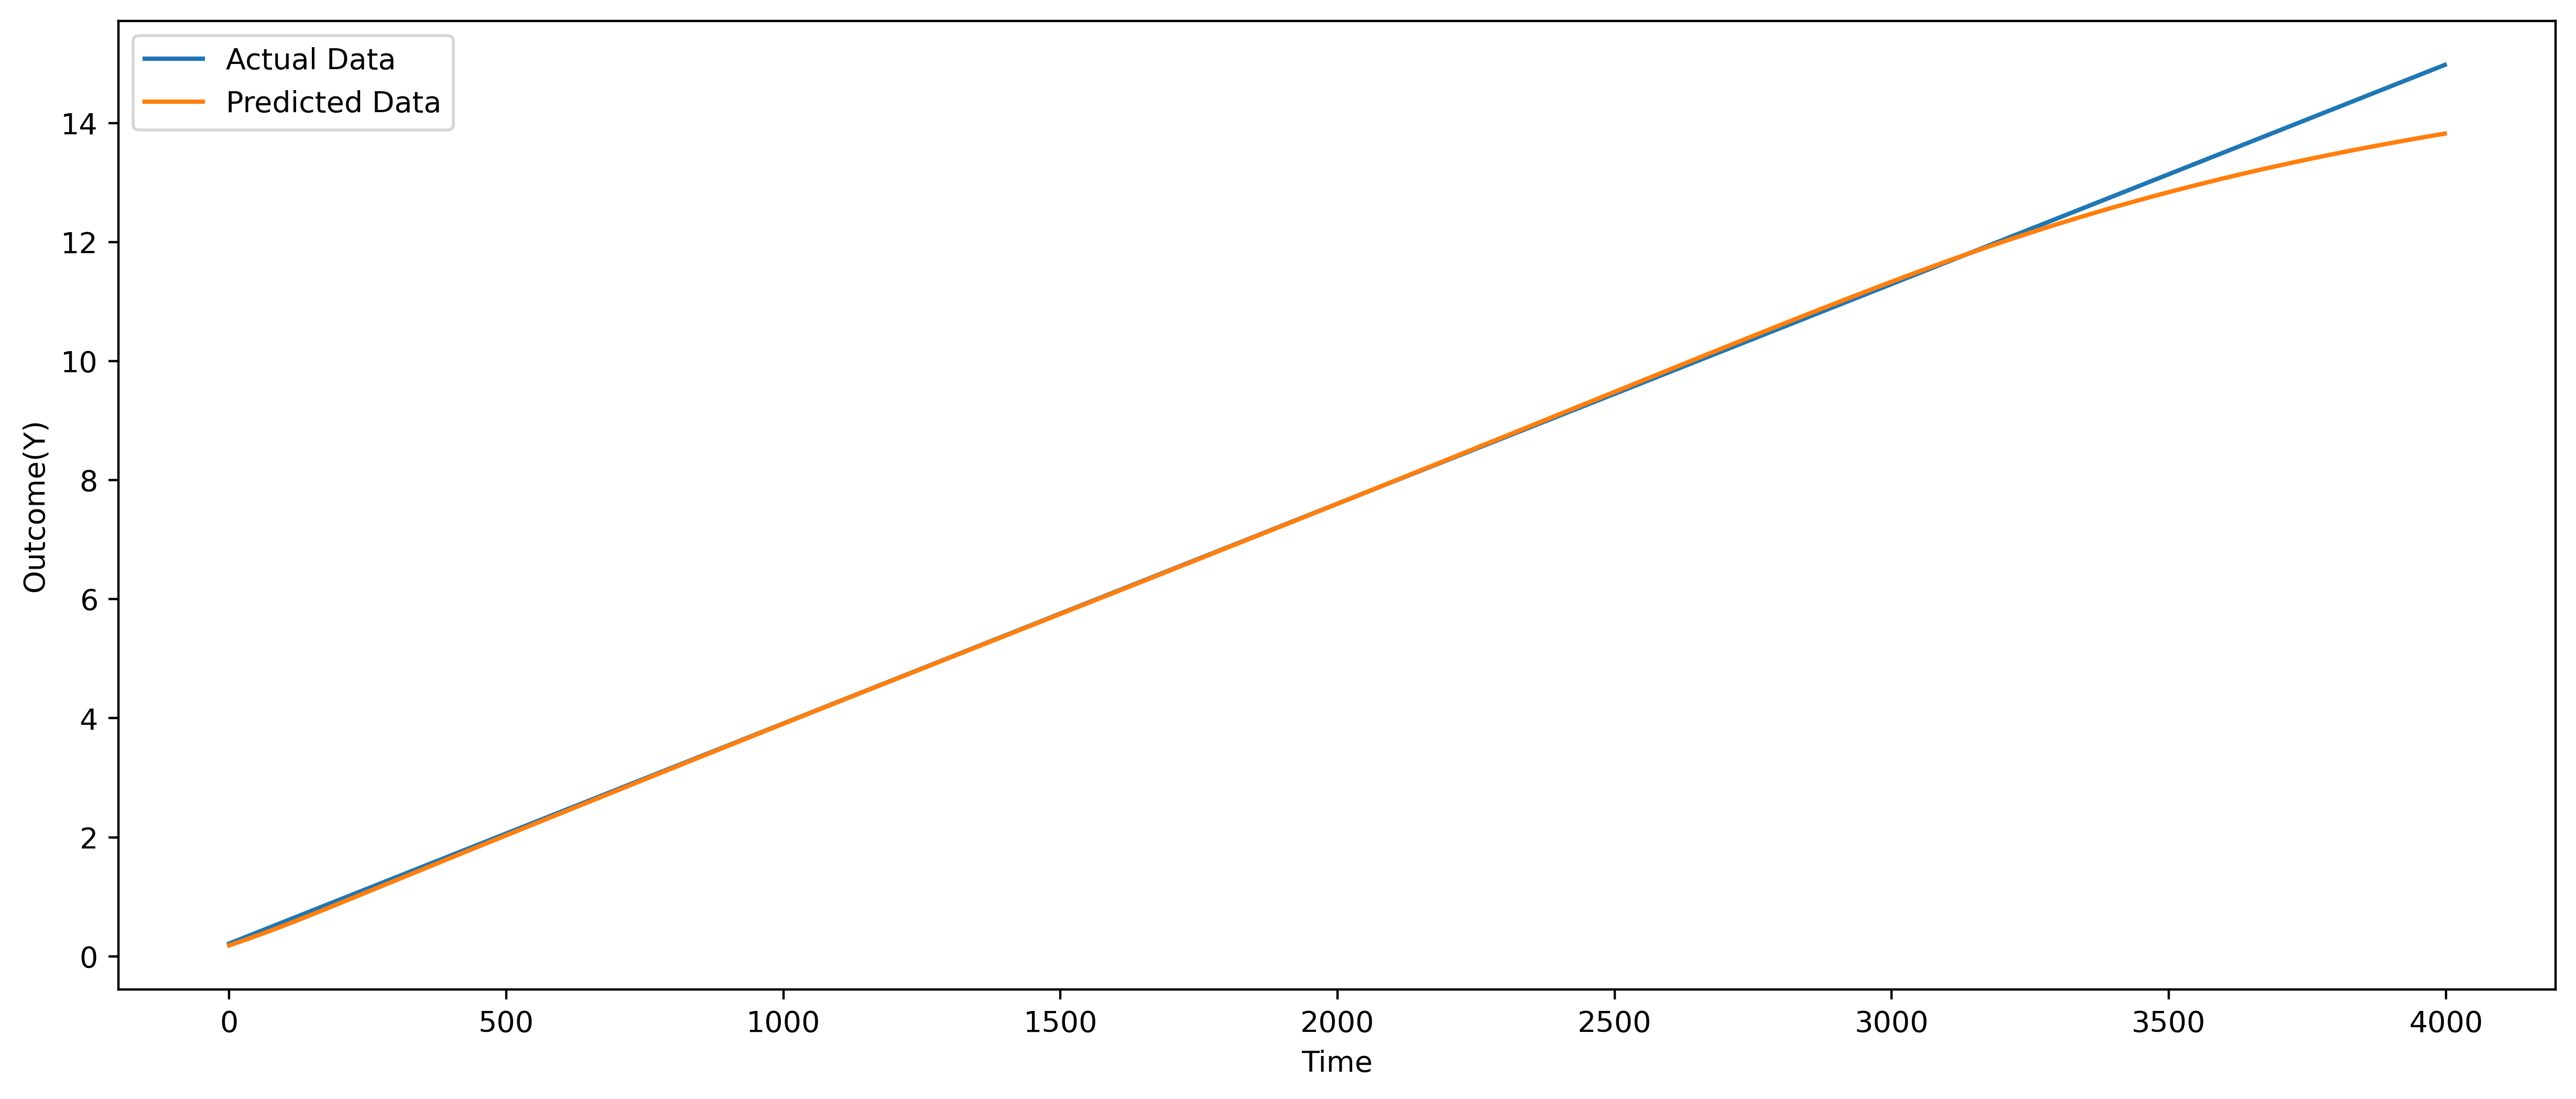

In [ ]:
fig,ax = plt.subplots(figsize = [15,6], dpi = 400)
ax.plot(range(ts),time_series7, label = "Actual Data")
ax.plot(range(ts),time_series8, label = "Predicted Data")
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel(r"Outcome(Y)")